In [8]:
import read_load_data
import read_watervalues
import read_wind_data
import read_inflow_scenarios

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Native libraries
import os
import math
# Essential Libraries
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from fcmeans import FCM
# Algorithms

## SVM and GAK

In [9]:
inflow_scenarios = read_inflow_scenarios.read_inflow_scenarios()

In [10]:
## assign the scenarios for each hydro module

inflow_data_regulated = {str(mod):{scen:inflow_scenarios['regulated'][scen][str(mod)]  for scen in range(50)}for mod in range(49901, 49913) }
inflow_data_unregulated = {str(mod):{scen:inflow_scenarios['unregulated'][scen][str(mod)]  for scen in range(50)}for mod in range(49901, 49913) }


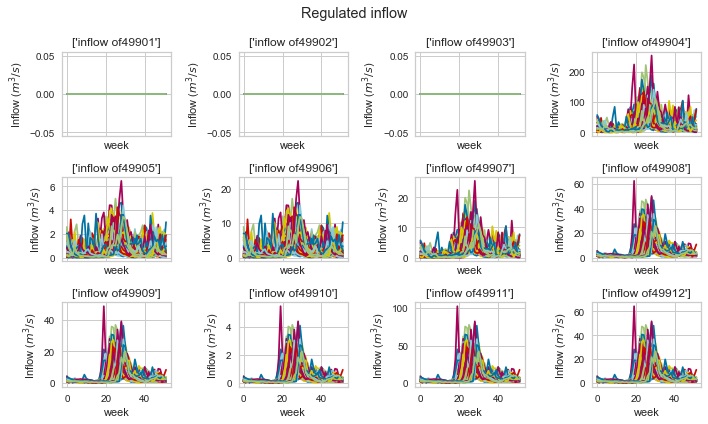

In [11]:
## plot scenarios for each time step(plot function) (regulated)
## transfer to df
def transform_to_df(module):
    flow= pd.DataFrame.from_dict(inflow_data_regulated[str(module)],orient='index')
    return flow

fig, axs = plt.subplots(3,4, figsize=(10, 6),sharex=True,sharey=False)#constrained_layout=True)
fig.suptitle('Regulated inflow')
for i in range(3):
    for j in range(4):
        module=i*4+j+49901
        flow=transform_to_df(module)
        for scen in range(50):
            axs[i,j].plot(flow.iloc[scen])
        axs[i, j].set_title(['inflow of%s'% module])

for ax in axs.flat:
    ax.set(xlabel='week', ylabel='Inflow ($m^3/s$)')


fig.tight_layout()
plt.show()

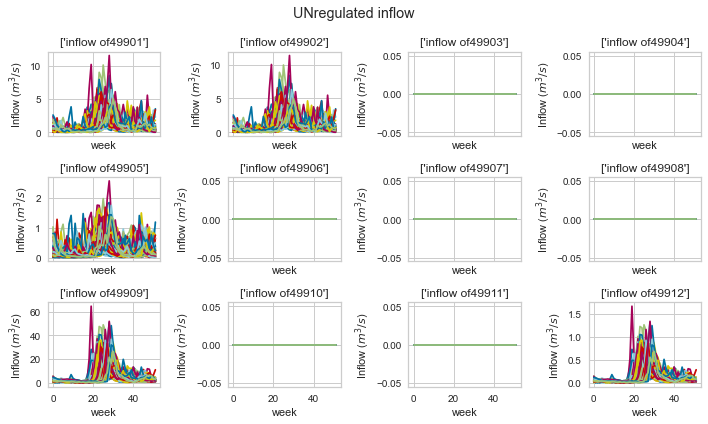

In [12]:
## plot scenarios for each time step(plot function) (regulated)
## transfer to df
def transform_to_df(module):
    flow= pd.DataFrame.from_dict(inflow_data_unregulated[str(module)],orient='index')
    return flow

fig, axs = plt.subplots(3,4, figsize=(10, 6),sharex=True,sharey=False)#constrained_layout=True)
fig.suptitle('UNregulated inflow')
for i in range(3):
    for j in range(4):
        module=i*4+j+49901
        flow=transform_to_df(module)
        for scen in range(50):
            axs[i,j].plot(flow.iloc[scen])
        axs[i, j].set_title(['inflow of%s'% module])

for ax in axs.flat:
    ax.set(xlabel='week', ylabel='Inflow ($m^3/s$)')


fig.tight_layout()
plt.show()


In [13]:
## import libraries
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
#from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from tslearn.utils import to_sklearn_dataset

In [42]:
seed = 0
reservoir=49911
np.random.seed(seed)
train_inf= np.array([inflow_data_regulated[str(reservoir)][scen] for scen in range(50)]).reshape(50,len(inflow_data_regulated['49904'][1]))
##Scale time series
Inflow_t=TimeSeriesScalerMeanVariance().fit_transform(train_inf)## train_inf[x] is a 52,1 array
#Inflow_t = TimeSeriesResampler(sz=27).fit_transform(Inflow_t)
sz = Inflow_t.shape[1]



Euclidean k-means(arithmetic mean)
    sqrt(sum(q_i-p_i)^2)
DBA k-means (DTW Barycenter Averaging)


Soft DTW k-means


silhouette
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [15]:
# Euclidean k-means
print("Euclidean k-means")
range_n_clusters = [ 2, 3, 4, 5, 6,7,8]
for n_clusters in range_n_clusters:
    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
    y_pred = km.fit_predict(Inflow_t)
    silhouette_avg = silhouette_score(Inflow_t, y_pred, metric="euclidean")
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)


Euclidean k-means
For n_clusters = 2 The average silhouette_score is : 0.3274616147386172
For n_clusters = 3 The average silhouette_score is : 0.2758519736557612
For n_clusters = 4 The average silhouette_score is : 0.21584159340808004
For n_clusters = 5 The average silhouette_score is : 0.2817691123443944
For n_clusters = 6 The average silhouette_score is : 0.26312547460266533
For n_clusters = 7 The average silhouette_score is : 0.22001164966841621
For n_clusters = 8 The average silhouette_score is : 0.19878811425743706


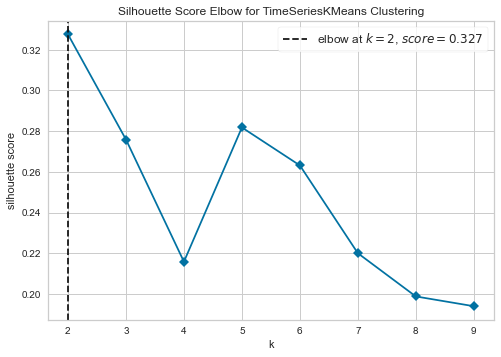

<AxesSubplot:title={'center':'Silhouette Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [16]:
#model = KMeans()
#visualizer = KElbowVisualizer(km, k=(2,12), metric='calinski_harabasz', timings=False)
visualizer = KElbowVisualizer(km, k=(2,10), metric='silhouette', timings=False)
#visualizer = SilhouetteVisualizer(TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed), colors='yellowbrick')
visualizer.fit(to_sklearn_dataset(Inflow_t))      # Fit the data to the visualizer
visualizer.show()

In [17]:
# DBA-k-means
print("DBA k-means")
for n_clusters in range_n_clusters:
    dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
    y_pred = dba_km.fit_predict(Inflow_t)
    silhouette_avg = silhouette_score(Inflow_t, y_pred, metric="dtw")
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

DBA k-means
For n_clusters = 2 The average silhouette_score is : 0.14015723630304763
For n_clusters = 3 The average silhouette_score is : 0.0852813585471287
For n_clusters = 4 The average silhouette_score is : 0.10279234967998323
For n_clusters = 5 The average silhouette_score is : 0.08086435504324205
For n_clusters = 6 The average silhouette_score is : 0.0793835013071749
For n_clusters = 7 The average silhouette_score is : 0.07937758029209775
For n_clusters = 8 The average silhouette_score is : 0.07435904445344008


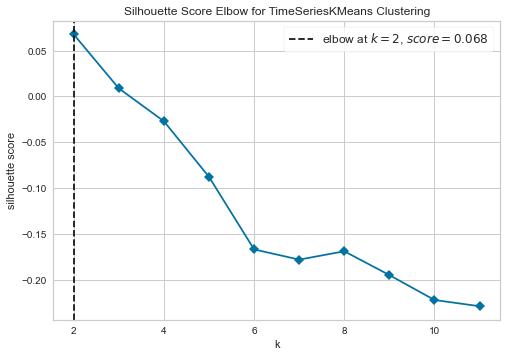

<AxesSubplot:title={'center':'Silhouette Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [18]:
#model = KMeans()
#visualizer = KElbowVisualizer(km, k=(2,12), metric='calinski_harabasz', timings=False)
visualizer = KElbowVisualizer(dba_km, k=(2,12), metric='silhouette', timings=False,verbose=False)
#visualizer = KElbowVisualizer(km, k=(2,12), metric='calinski_harabasz', timings=False)

visualizer.fit(to_sklearn_dataset(Inflow_t))      # Fit the data to the visualizer
visualizer.show()

In [19]:
# Soft-DTW-k-means
print("Soft-DTW k-means")

for n_clusters in range_n_clusters:
    sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .5},
                           verbose=False,
                           random_state=seed)
    y_pred = sdtw_km.fit_predict(train_inf)
    silhouette_avg = silhouette_score(train_inf, y_pred, metric="softdtw")
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

Soft-DTW k-means
For n_clusters = 2 The average silhouette_score is : 0.4810586415214344
For n_clusters = 3 The average silhouette_score is : 0.2537247085350581
For n_clusters = 4 The average silhouette_score is : 0.10982169694310168
For n_clusters = 5 The average silhouette_score is : 0.13654905731924288
For n_clusters = 6 The average silhouette_score is : 0.12112837616473797
For n_clusters = 7 The average silhouette_score is : 0.14128340928969593
For n_clusters = 8 The average silhouette_score is : 0.13523127816088365


Euclidean  k-means
DBA k-means
Soft-DTW k-means
fuzzy c-means


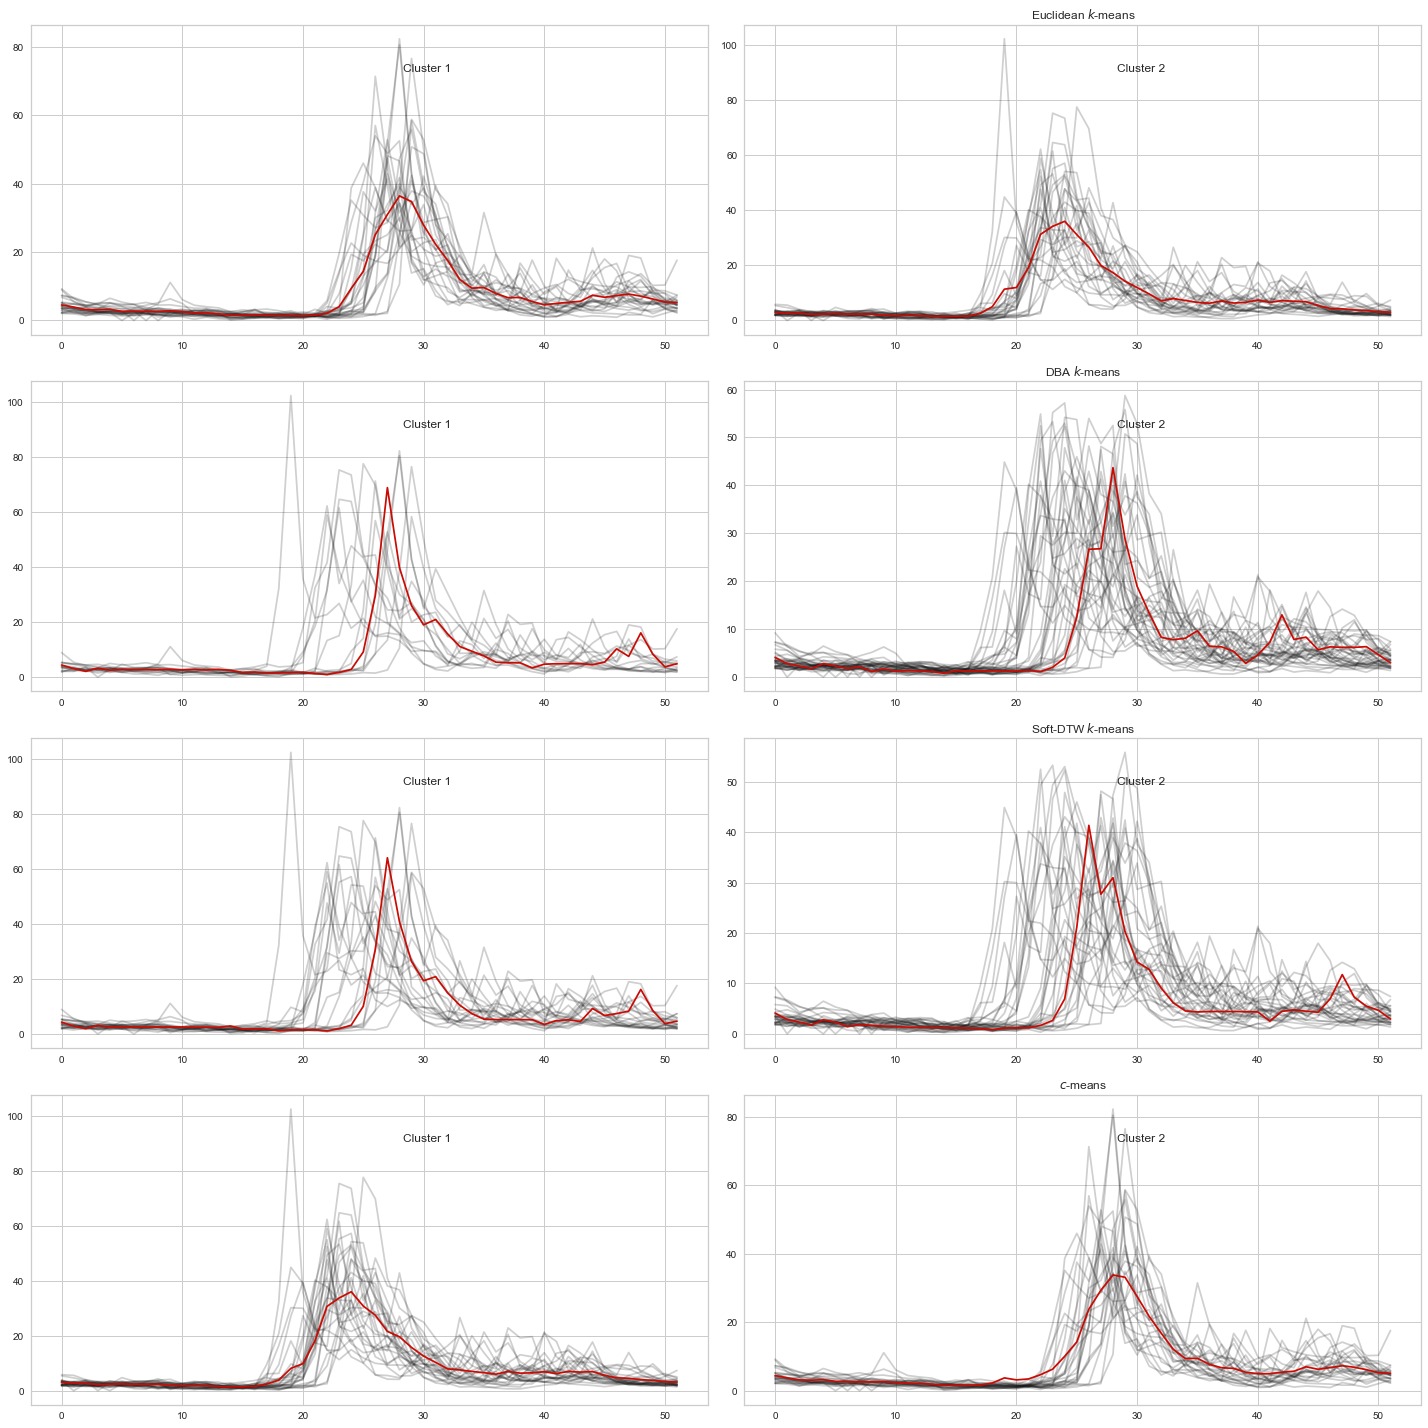

In [20]:
n_clusters=2
#Euclidean $k$-means
print("Euclidean  k-means")
plt.figure(figsize=(20,20))
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred = km.fit_predict(train_inf)
for yi in range(n_clusters):
    plt.subplot(4, n_clusters, yi + 1)
    for xx in train_inf[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")


# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(train_inf)
for yi in range(n_clusters):
    plt.subplot(4, n_clusters, n_clusters+1 + yi)
    for xx in train_inf[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .1},
                           verbose=False,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(train_inf)
for yi in range(n_clusters):
    plt.subplot(4, n_clusters, 2*n_clusters+1 + yi)
    for xx in train_inf[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

## fuzzy c-means ( Overlapping Clustering )
print("fuzzy c-means")
fcm_km= FCM(n_clusters=n_clusters,cluster_std=2.0,
                  shuffle=False, random_state=42,error=1e-5)
fcm_km.fit(train_inf)
# outputs
y_pred = fcm_km.predict(train_inf)

for yi in range(n_clusters):
    plt.subplot(4, n_clusters, 3*n_clusters+1 + yi)
    for xx in train_inf[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(fcm_km.centers[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("$c$-means")

plt.tight_layout()
plt.show()

In [21]:
#Learning Shapelets (shape-based clustering)

from sklearn.metrics import accuracy_score
import tensorflow as tf
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
from matplotlib import cm

In [22]:
# creat training and testing data set
lab=np.ones((30,))
lab_test=np.ones((20,))
X_train = train_inf[:30] ## 30s
X_test = train_inf[30:52]## 20s
y_train=y_pred[0:30]+lab  ##
y_test=y_pred[30:50]+lab_test
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

In [23]:
# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)
#shapelet_sizes = {10: 3}
# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(learning_rate=0.01),
                            batch_size=1600,
                            weight_regularizer=.0001,
                            max_iter=1000,
                            random_state=42,
                            scale=False,
                            verbose=0)
shp_clf.fit(X_train, y_train)
distances = shp_clf.transform(X_train)
weights, biases = shp_clf.get_weights("classification")

C:\Users\jinghaow\software\Anaconda3\envs\ENVOIRMENT_1\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [24]:
weights

array([[ 0.02103378],
       [-1.2353911 ],
       [ 0.00272743]], dtype=float32)

Correct classification rate: 0.2


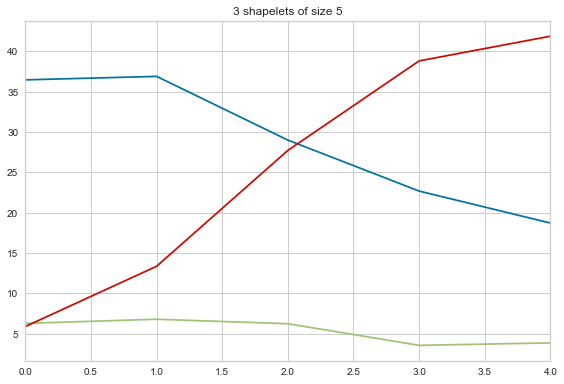

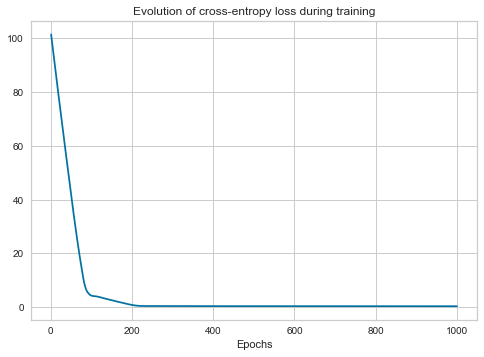

In [25]:

# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))

# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

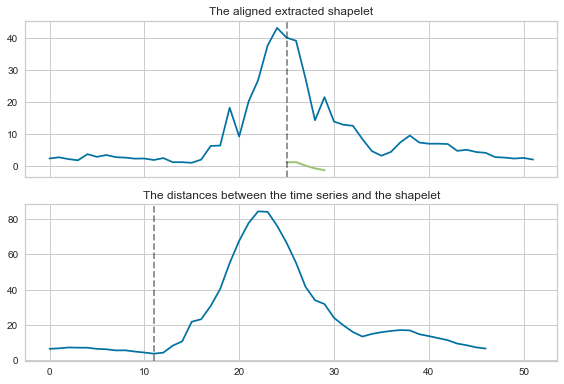

In [26]:
#n_shapelets = sum(shapelet_sizes.values())
#distances = shp_clf.transform(X_train)
#weights, biases = shp_clf.get_weights("classification")
predicted_locations = shp_clf.locate(X_train)

f, ax = plt.subplots(2, 1, sharex=True)

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.
test_ts_id = np.argmin(np.sum(distances, axis=1))
shap = shp_clf.shapelets_[0]
shap =TimeSeriesScalerMeanVariance().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, 0]
ax[0].plot(X_train[test_ts_id].ravel())
ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.5)
ax[0].set_title("The aligned extracted shapelet")

# We calculate the distances from the shapelet to the timeseries ourselves.
distances1 = []
time_series = X_train[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances1.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))
ax[1].plot(distances1)
ax[1].axvline(np.argmin(distances1), color='k', linestyle='--', alpha=0.5)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()

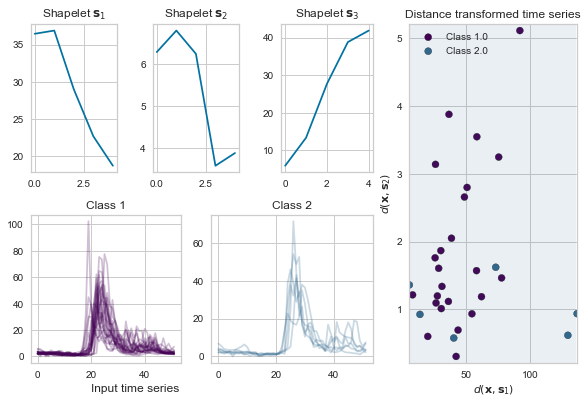

In [27]:
#distances = shp_clf.transform(X_train)
#weights, biases = shp_clf.get_weights('classification')

# Create a grid for our two shapelets on the left and distances on the right
viridis = cm.get_cmap('viridis', 4)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 9)
fig_ax1 = fig.add_subplot(gs[0, :2])
fig_ax2 = fig.add_subplot(gs[0, 2:4])
fig_ax3 = fig.add_subplot(gs[0, 4:6])
fig_ax3a = fig.add_subplot(gs[1, :3])
fig_ax3b = fig.add_subplot(gs[1, 3:6])
fig_ax4 = fig.add_subplot(gs[:, 6:])

# Plot our two shapelets on the left side
fig_ax1.plot(shp_clf.shapelets_[0])
fig_ax1.set_title('Shapelet $\mathbf{s}_1$')

fig_ax2.plot(shp_clf.shapelets_[1])
fig_ax2.set_title('Shapelet $\mathbf{s}_2$')

fig_ax3.plot(shp_clf.shapelets_[2])
fig_ax3.set_title('Shapelet $\mathbf{s}_3$')

# Create the time series of each class
for i, subfig in enumerate([fig_ax3a, fig_ax3b]):
    for k, ts in enumerate(X_train[y_train == i+1 ]):
        subfig.plot(ts.flatten(), c=viridis(i / 3), alpha=0.25)
        subfig.set_title('Class {}'.format(i + 1))
fig.text(x=.15, y=.02, s='Input time series', fontsize=12)

# Create a scatter plot of the 2D distances for the time series of each class.
for i, y in enumerate(np.unique(y_train)):
    fig_ax4.scatter(distances[y_train == y][:, 0],
                    distances[y_train == y][:, 1],
                    c=[viridis(i / 3)] * np.sum(y_train == y),
                    edgecolors='k',
                    label='Class {}'.format(y))

# Create a meshgrid of the decision boundaries
xmin = np.min(distances[:, 0]) - 0.1
xmax = np.max(distances[:, 0]) + 0.1
ymin = np.min(distances[:, 1]) - 0.1
ymax = np.max(distances[:, 1]) + 0.1
xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin)/200),
                        np.arange(ymin, ymax, (ymax - ymin)/200))
Z = []
for x, y in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(np.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                           for i in range(1)]))
Z = np.array(Z).reshape(xx.shape)
cs = fig_ax4.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.1)

fig_ax4.legend()
fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed time series')
plt.show()

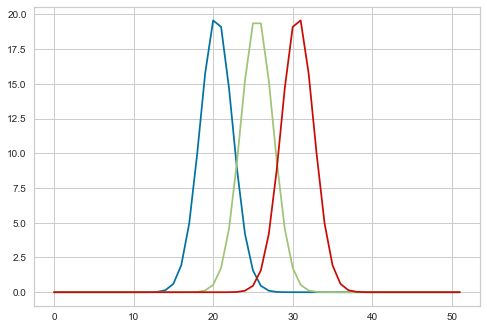

In [28]:
import scipy.stats as stats
import math




x = np.linspace(0, 50, 52)
plt.plot(stats.norm.pdf(x, 20, 2)*100)
plt.plot(stats.norm.pdf(x, 25, 2)*100)
plt.plot(stats.norm.pdf(x, 30, 2)*100)
plt.show()

In [29]:
### hierarchy clustering
##Inflow_t standardlized
from scipy.cluster.hierarchy import dendrogram, linkage
# Here we use spearman correlation
def my_metric(x, y):
    r = stats.pearsonr(x, y)[0]
    return 1 - r # correlation to distance: range 0 to 2

In [56]:
# Do the clustering
## what is distance

##Inflow_t scaled
## train_inf original daya

Z = linkage(train_inf, method='single', metric='correlation')## correlation

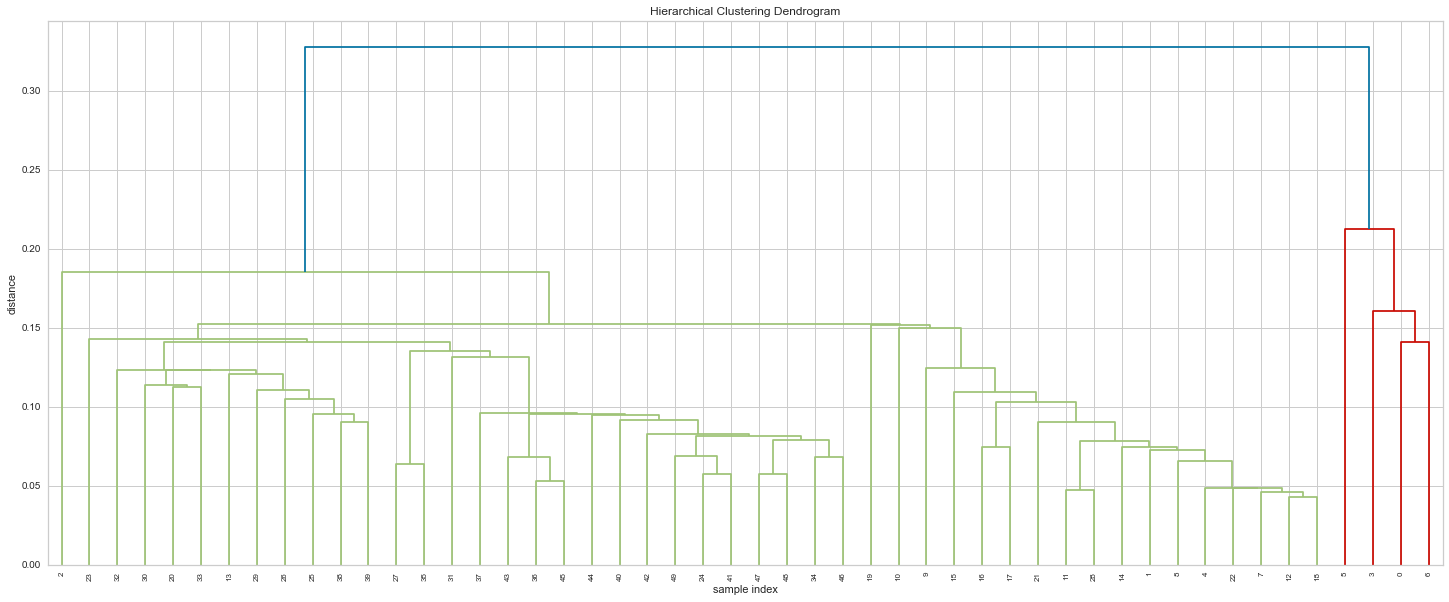

In [57]:

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

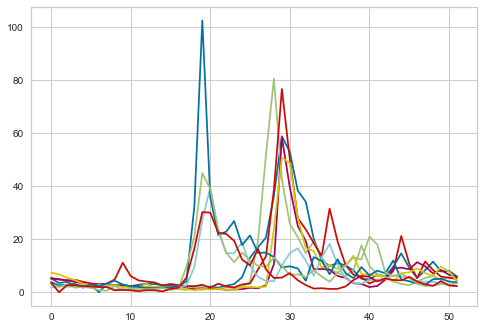

In [60]:

plt.plot(train_inf[34])
plt.plot(train_inf[36])
plt.plot(train_inf[42])
plt.plot(train_inf[47])
plt.plot(train_inf[48])


## cluster 2

plt.plot(train_inf[5])
plt.plot(train_inf[3])
plt.plot(train_inf[0])
plt.plot(train_inf[6])




plt.show()

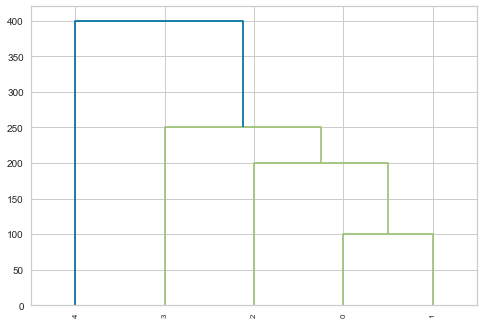

In [59]:
# Python program to plot the hierarchical
# clustering dendrogram using SciPy

# Import the python libraries
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# Create an array
x = np.array([100, 200, 300, 400, 500, 250,450, 280, 450, 750])

# Plot the hierarchical clustering as a dendrogram.
temp = hierarchy.linkage(x, 'single')
plt.figure()

dn = dendrogram(
    temp, above_threshold_color="green", color_threshold=.7)